## Shor's code

<img src="shor.png" width="500" height="300" />

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.quantum_info import Statevector, random_statevector
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UGate
from numpy.random import randint
import numpy as np


In [3]:
def encoder(qc):
    # Step 1 -> 2 (Phase flip code)
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h(0)
    qc.h(3)
    qc.h(6)
    qc.barrier()
    # Step 2 -> 3 (Bit flip code)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(3, 4)
    qc.cx(3, 5)
    qc.cx(6, 7)
    qc.cx(6, 8)

In [4]:
def _syndrome_measurement_bit_flip(qc, q1, aq0, cl0):
    # Measure the parity between q1 and q2
    qc.cx(q1, aq0)
    qc.cx(q1+1, aq0)
    qc.measure(aq0, cl0)
    # Measure the parity between q2 and q3
    qc.cx(q1+1, aq0+1)
    qc.cx(q1+2, aq0+1)
    qc.measure(aq0+1, cl0+1)

def syndrome_measurement_bit_flip(qc):
    _syndrome_measurement_bit_flip(qc, 0, 9, 0)
    qc.barrier()
    _syndrome_measurement_bit_flip(qc, 3, 11, 2)
    qc.barrier()
    _syndrome_measurement_bit_flip(qc, 6, 13, 4)

def _decoder_bit_flip(qc, n_qubit_error_block, n_qubit_error=None):
    q1 = 3*n_qubit_error_block
    if n_qubit_error is None:
        qc.cx(q1, q1+1)
        qc.cx(q1, q1+2)
        qc.ccx(q1+1, q1+2, q1)
    else:
        intact_qubits = list({q1, q1+1, q1+2}.difference([n_qubit_error]))
        qc.cx(n_qubit_error, intact_qubits[0])
        qc.cx(n_qubit_error, intact_qubits[1])
        qc.ccx(intact_qubits[0], intact_qubits[1], n_qubit_error)


def decoder_bit_flip(qc, n_qubit_error=None):
    if n_qubit_error is None:
       _decoder_bit_flip(qc, 0)
       _decoder_bit_flip(qc, 1)
       _decoder_bit_flip(qc, 2)
    else:
        n_qubit_error_block = int(n_qubit_error/3)
        _decoder_bit_flip(qc, n_qubit_error_block, n_qubit_error)
        for n in {0, 1, 2}.difference([n_qubit_error_block]):  _decoder_bit_flip(qc, n)


In [5]:

def syndrome_measurement_phase_flip(qc):
    # Change the base
    for i in range(9): qc.h(i)
    # Measure Z1Z2Z3Z4Z5Z6
    qc.cx(0, 15)
    qc.cx(1, 15)
    qc.cx(2, 15)
    qc.cx(3, 15)
    qc.cx(4, 15)
    qc.cx(5, 15)
    qc.measure(15, 6)
    # Measure Z4Z5Z6Z7Z8Z9
    qc.cx(3, 16)
    qc.cx(4, 16)
    qc.cx(5, 16)
    qc.cx(6, 16)
    qc.cx(7, 16)
    qc.cx(8, 16)
    qc.measure(16, 7)
    # Change the base
    for i in range(9): qc.h(i)

def decoder_phase_flip(qc, n_qubit_error=None):
    if n_qubit_error is None:
        qc.h(0)
        qc.h(3)
        qc.h(6)
        qc.cx(0, 3)
        qc.cx(0, 6)
    else:
        n_qubit_error_block = int(n_qubit_error/3)
        intact_blocks = list({0, 1, 2}.difference([n_qubit_error_block]))
        qc.h(n_qubit_error)
        qc.h(3*intact_blocks[0])
        qc.h(3*intact_blocks[1])
        qc.cx(n_qubit_error, 3*intact_blocks[0])
        qc.cx(n_qubit_error, 3*intact_blocks[1])
        qc.ccx(3*intact_blocks[0], 3*intact_blocks[1], n_qubit_error)

In [6]:
def qec_shors_flip(quantum_gate_state, f_error, n_qubit_error = None):
    tq = QuantumRegister(1, 'transmitted_qubit')
    cq = [QuantumRegister(1, f'code_qubit{i}') for i in range(1, 9)]
    aq = QuantumRegister(8, 'ancilla_qubit')
    sb = ClassicalRegister(8, 'syndrome_bit')
    qc = QuantumCircuit(
                        tq, 
                        *cq,
                        aq,
                        sb
                       )
    
    qc.append(quantum_gate_state, tq)
    qc.barrier()
    # ENCODING
    encoder(qc)
    qc.barrier()
    # ERROR
    if n_qubit_error is not None:
        if n_qubit_error == 0:
            q_error = tq
        else:
            q_error = cq[n_qubit_error-1]
    else:
        q_error = None
    if q_error is not None:
        f_error(qc, q_error)
    else:
        f_error(qc)
    qc.barrier()
    # SYNDROME MEASUREMENT
    syndrome_measurement_bit_flip(qc)
    qc.barrier()
    syndrome_measurement_phase_flip(qc)
    qc.barrier()

    # DECODING
    check_result = ClassicalRegister(1, "Result")
    qc.add_register(check_result)
    def decoder_conditional_syndrome_analysis(qc, syndrome_analysis_result):
        result_bf = syndrome_analysis_result[2:]
        result_pf = syndrome_analysis_result[:2]

        # Compute q_err_bf, tq1_bf
        if syndrome_analysis_result == '000001': 
            q_err_bf = 0
            tq1_bf = tq
        elif syndrome_analysis_result == '000011': 
            q_err_bf = 1
            tq1_bf = cq[0]
        elif syndrome_analysis_result == '000010': 
            q_err_bf = 2
            tq1_bf = cq[1]
        elif syndrome_analysis_result == '000100': 
            q_err_bf = 3
            tq1_bf = cq[2]
        elif syndrome_analysis_result == '001100': 
            q_err_bf = 4
            tq1_bf = cq[3]
        elif syndrome_analysis_result == '001000': 
            q_err_bf = 5
            tq1_bf = cq[4]
        elif syndrome_analysis_result == '010000': 
            q_err_bf = 6
            tq1_bf = cq[5]
        elif syndrome_analysis_result == '110000': 
            q_err_bf = 7
            tq1_bf = cq[6]
        elif syndrome_analysis_result == '100000': 
            q_err_bf = 8
            tq1_bf = cq[7]
        else:
            q_err_bf = None

        # Compute q_err_pf, tq1_pf
        if result_pf == '00':
            q_err_pf = None
            tq1_pf = tq
        elif result_pf == '01':
            q_err_pf = 0
            tq1_pf = tq
        elif result_pf == '10':
            q_err_pf = 3
            tq1_pf = cq[2]
        elif result_pf == '11':
            q_err_pf = 6
            tq1_pf = cq[5]

        if q_err_bf is not None:
            q_err = q_err_bf
            tq1 = tq1_bf
        else:
            q_err = q_err_pf
            tq1 = tq1_pf
        

        return q_err, tq1

    possibilities_syndrome_analysis = [
                                       '00000001',
                                       '00000011',
                                       '00000010',
                                       '01000001',
                                       '01000011',
                                       '01000010',
                                       '00000100',
                                       '00001100',
                                       '00001000',
                                       '11000100',
                                       '11001100',
                                       '11001000',
                                       '00010000',
                                       '00110000',
                                       '00100000',
                                       '10010000',
                                       '10110000',
                                       '10100000'
                                      ]

    for b in possibilities_syndrome_analysis:
        q_err, tq1 = decoder_conditional_syndrome_analysis(qc, b)
        n_case = int(b, 2)
        with qc.if_test((sb, n_case)):
            decoder_bit_flip(qc, q_err)
            decoder_phase_flip(qc, q_err)
            # Measure check result
            qc.append(quantum_gate_state.inverse(), tq1)
            qc.measure(tq1, check_result)

    return qc

## ----------------

## Correct Bit Flip ERROR

In [7]:
quantum_gate_state = UGate(
                            theta=np.random.random() * 2 * np.pi,
                            phi=np.random.random() * 2 * np.pi,
                            lam=np.random.random() * 2 * np.pi,
                          )

ERROR: X_0


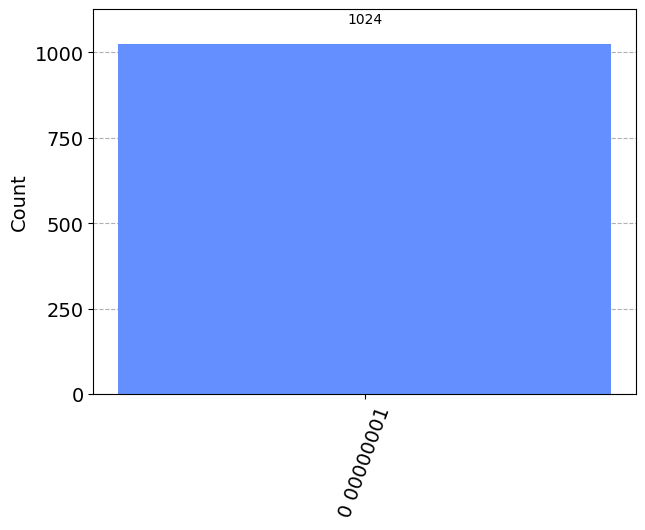

ERROR: X_1


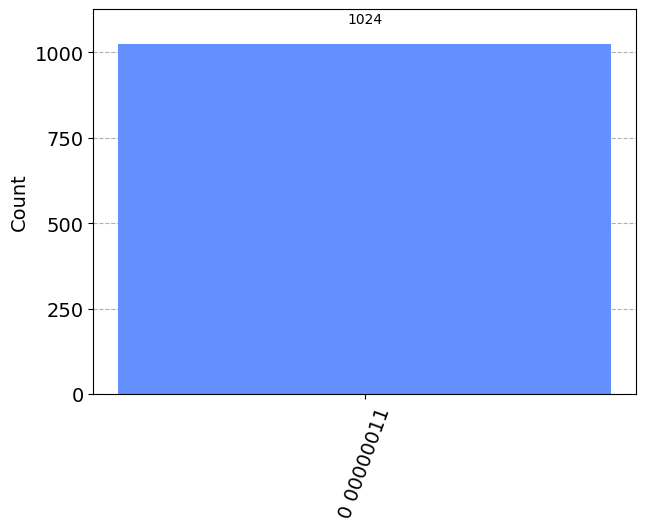

ERROR: X_2


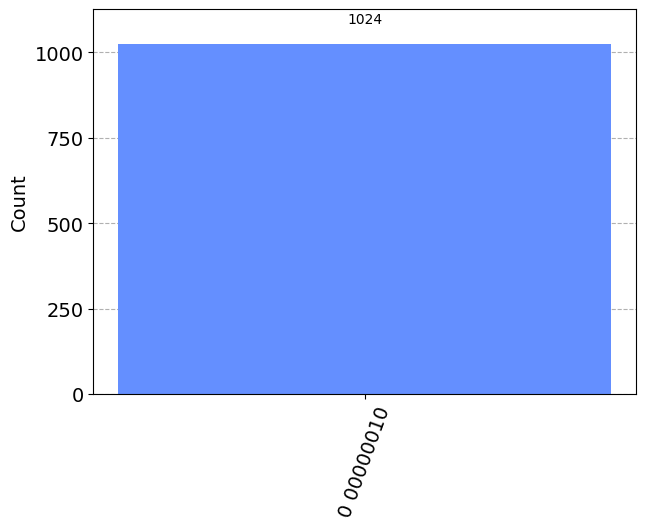

ERROR: X_3


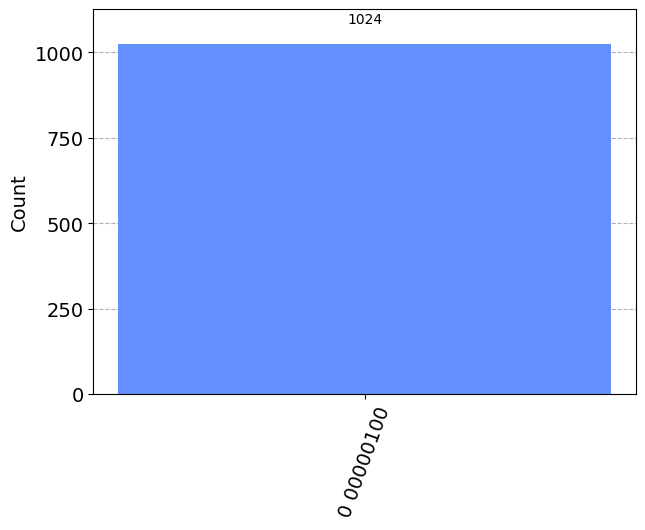

ERROR: X_4


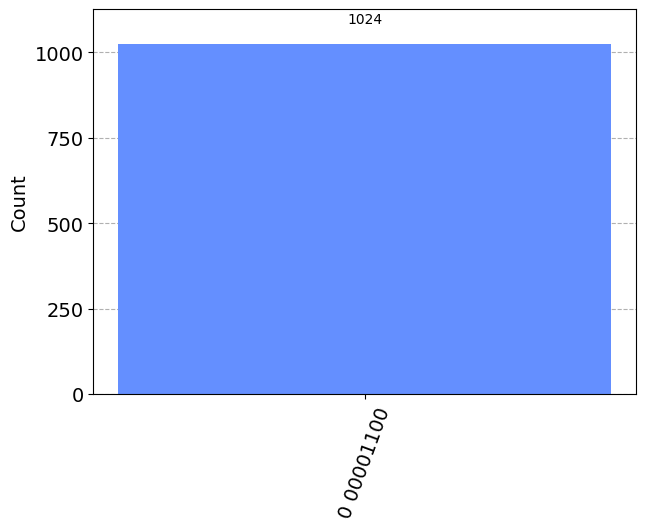

ERROR: X_5


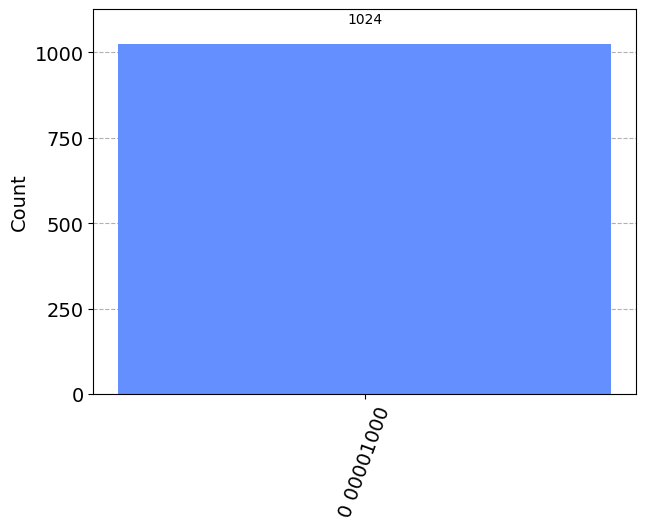

ERROR: X_6


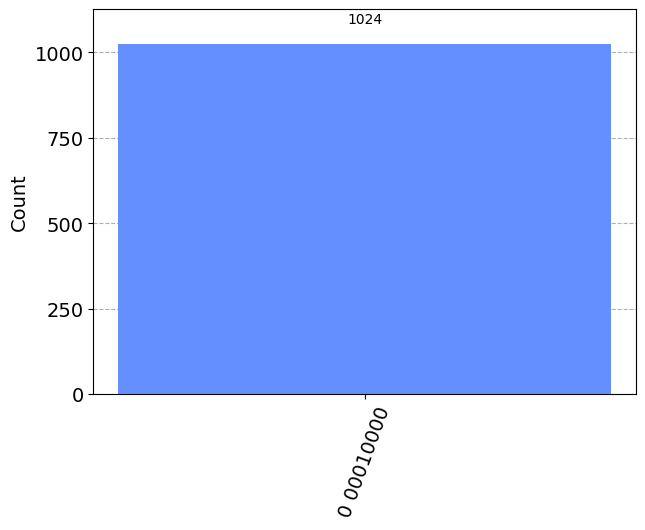

ERROR: X_7


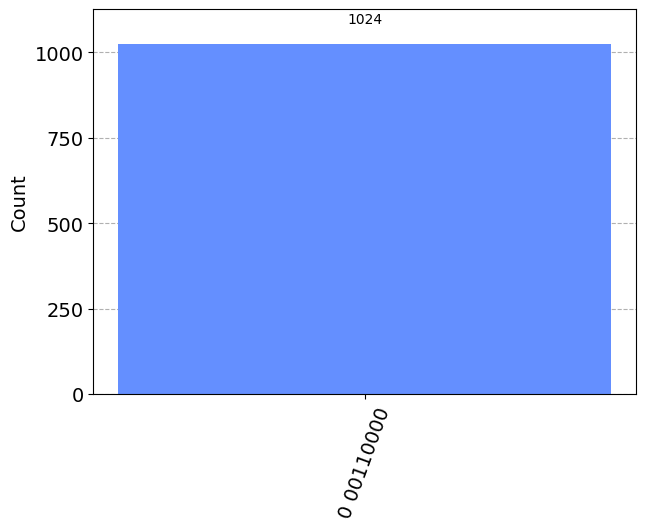

ERROR: X_8


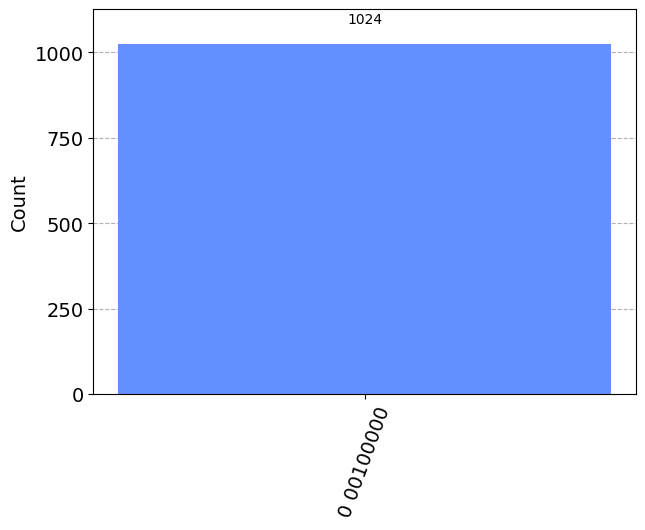

In [8]:
for i in range(9):
    print(f'ERROR: X_{i}')
    
    f_error = lambda qc: qc.x(i)
    qc = qec_shors_flip(quantum_gate_state, f_error)

    counts = AerSimulator().run(qc).result()
    statistics = counts.get_counts()
    display(plot_histogram(statistics))

## Correct Phase Flip ERROR

In [9]:
quantum_gate_state = UGate(
                            theta=np.random.random() * 2 * np.pi,
                            phi=np.random.random() * 2 * np.pi,
                            lam=np.random.random() * 2 * np.pi,
                          )

ERROR: Z_0


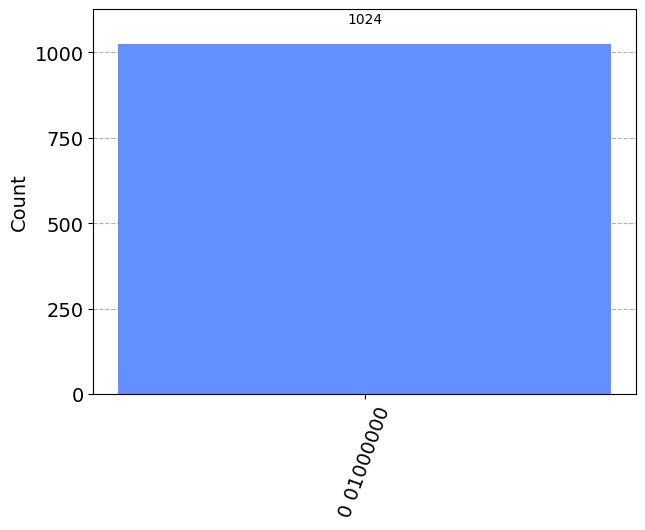

ERROR: Z_1


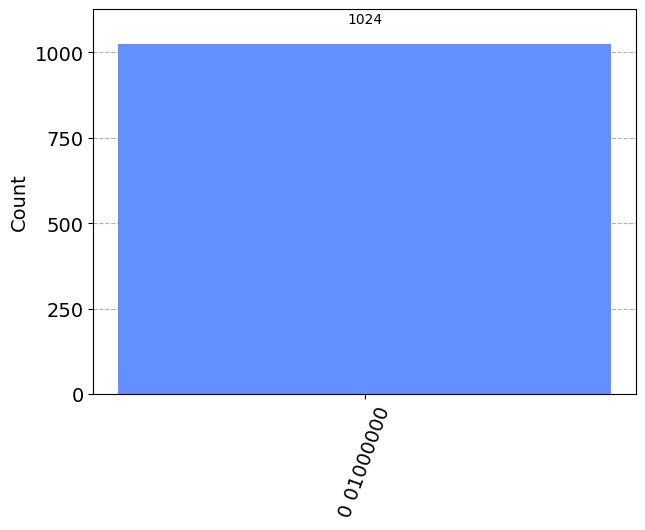

ERROR: Z_2


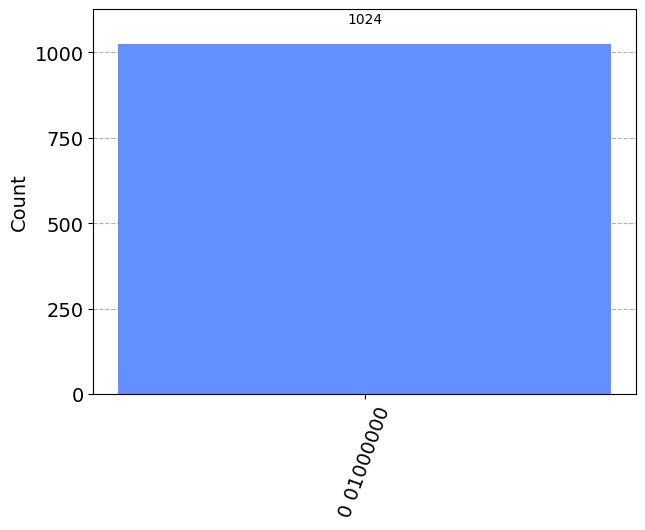

ERROR: Z_3


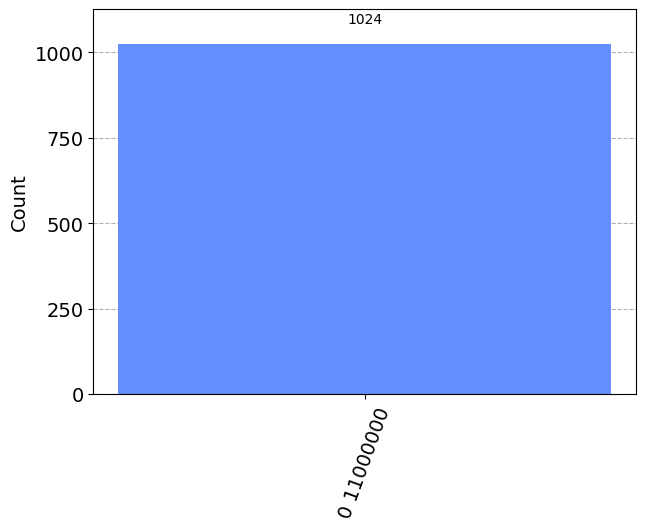

ERROR: Z_4


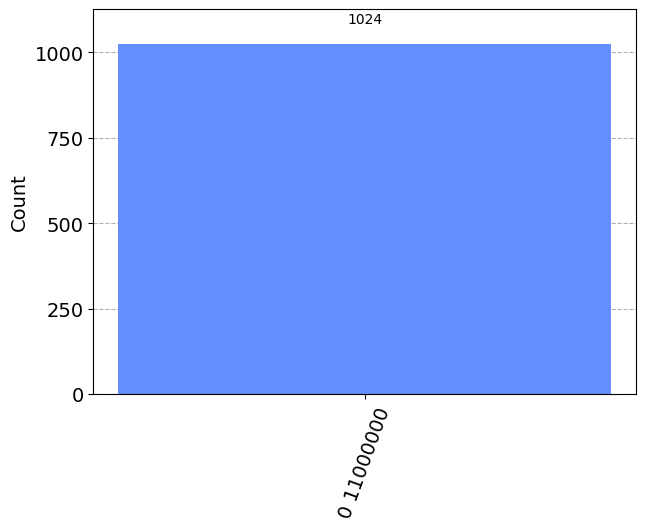

ERROR: Z_5


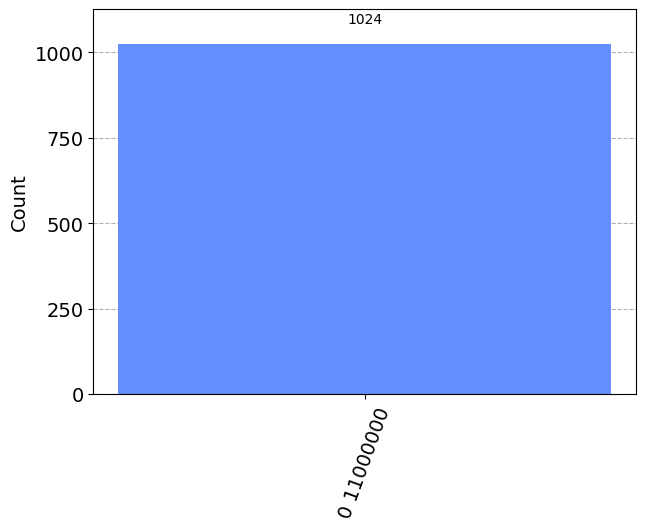

ERROR: Z_6


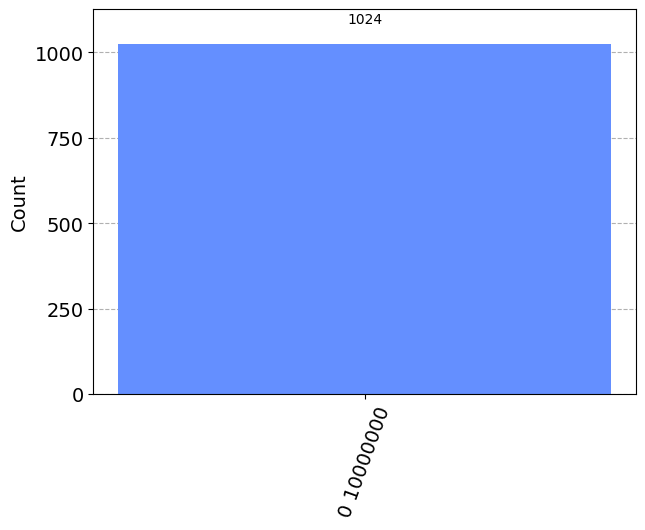

ERROR: Z_7


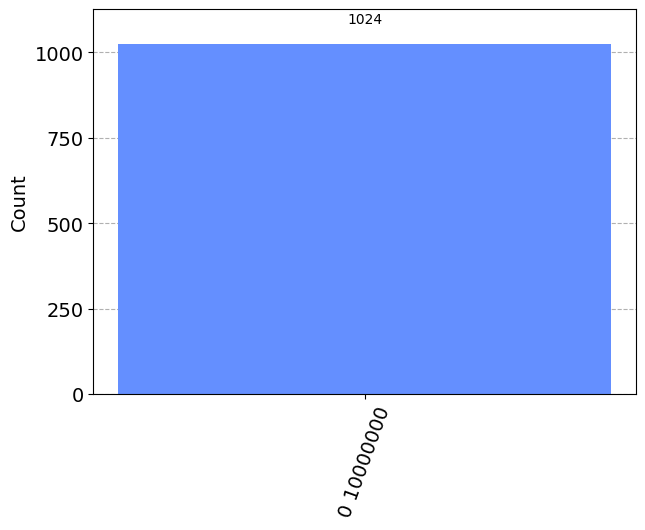

ERROR: Z_8


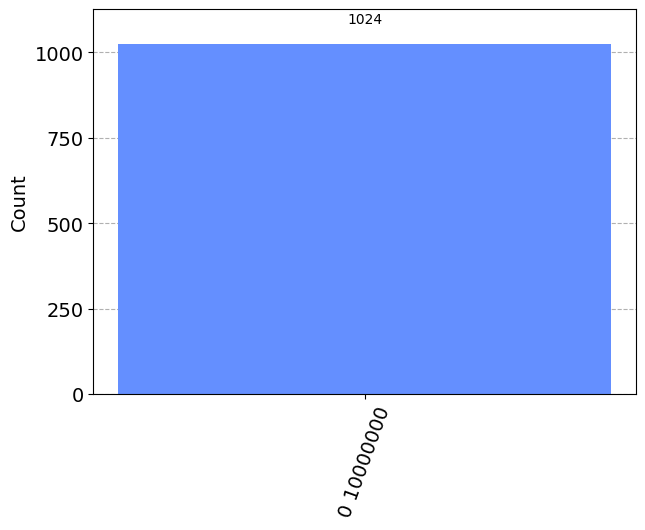

In [10]:
for i in range(9):
    print(f'ERROR: Z_{i}')
    
    f_error = lambda qc: qc.z(i)
    qc = qec_shors_flip(quantum_gate_state, f_error)

    counts = AerSimulator().run(qc).result()
    statistics = counts.get_counts()
    display(plot_histogram(statistics))

## Correct Random Unitary ERROR

In [11]:
quantum_gate_state = UGate(
                            theta=np.random.random() * 2 * np.pi,
                            phi=np.random.random() * 2 * np.pi,
                            lam=np.random.random() * 2 * np.pi,
                          )

In [12]:
quantum_unitary_error = UGate(
                              theta=np.random.random() * 2 * np.pi,
                              phi=np.random.random() * 2 * np.pi,
                              lam=np.random.random() * 2 * np.pi,
                             )

random_qubit_error = np.random.randint(9)

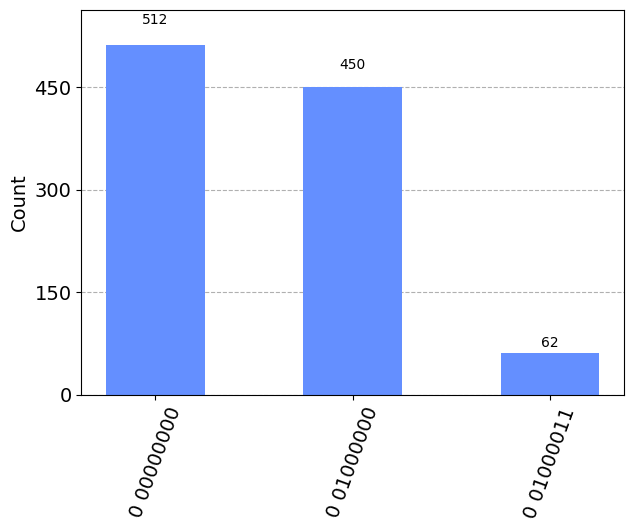

In [13]:
f_error = lambda qc, q_error: qc.append(quantum_unitary_error, q_error)
qc = qec_shors_flip(quantum_gate_state, f_error, random_qubit_error)

counts = AerSimulator().run(qc).result()
statistics = counts.get_counts()
display(plot_histogram(statistics))

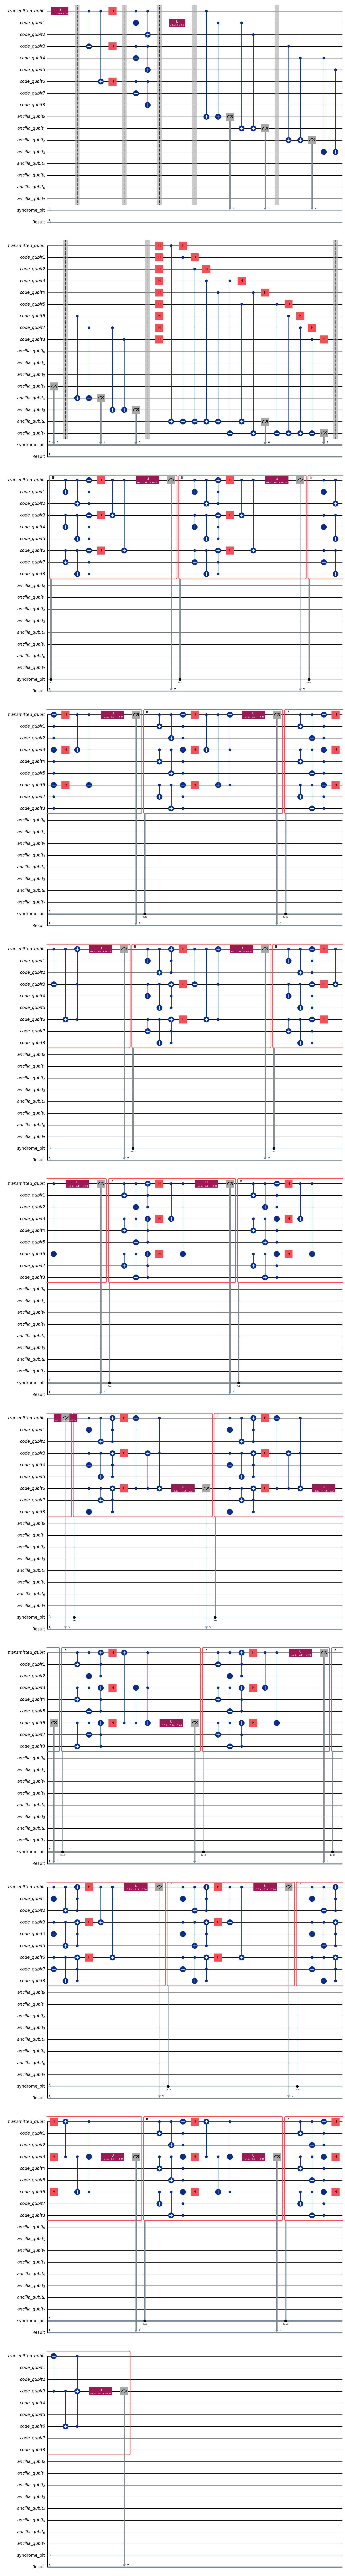

In [14]:
qc.draw(output="mpl", style="iqp")